In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'Colab/Courses/CS231n/Assignment1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/Colab/Courses/CS231n/Assignment1/cs231n/datasets
/content/drive/My Drive/Colab/Courses/CS231n/Assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [ ]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.367399
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ 

At the very start, the weights would all be small and random, so the predictions for each class will have almost the same probability. This probability would be close to 1/num_classes. The loss for this example would be -log(1/num_classes). The loss is aggregated over all examples and then divided by the number of examples. But in this case, the loss over all samples would similar. 

So total loss =  num_samples * -log(1/num_classses) / num_samples 

==> total_loss = -log(1/num_classes)

Here num_classes = 10

==> total_loss = -log(0.1)



In [ ]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

print ()

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.047796 analytic: 1.047796, relative error: 2.793545e-08
numerical: -0.856710 analytic: -0.856710, relative error: 1.146025e-08
numerical: 1.525040 analytic: 1.525040, relative error: 1.655823e-08
numerical: -2.830349 analytic: -2.830349, relative error: 2.241515e-09
numerical: -0.265605 analytic: -0.265605, relative error: 8.992416e-10
numerical: -0.972904 analytic: -0.972904, relative error: 7.710546e-08
numerical: 0.810006 analytic: 0.810006, relative error: 3.902055e-08
numerical: 1.330633 analytic: 1.330633, relative error: 1.185004e-08
numerical: 1.151637 analytic: 1.151637, relative error: 8.509357e-08
numerical: -0.482301 analytic: -0.482301, relative error: 1.175038e-08

numerical: 2.017910 analytic: 2.017910, relative error: 2.356252e-08
numerical: -0.317287 analytic: -0.317287, relative error: 4.262543e-08
numerical: -0.938125 analytic: -0.938126, relative error: 7.054291e-08
numerical: -0.081708 analytic: -0.081708, relative error: 4.879999e-08
numerical: -2.297

In [ ]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.367399e+00 computed in 0.151417s
vectorized loss: 2.367399e+00 computed in 0.018074s
Loss difference: 0.000000
Gradient difference: 0.000000


In [ ]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 772.289837
iteration 100 / 1500: loss 283.580698
iteration 200 / 1500: loss 105.176873
iteration 300 / 1500: loss 39.853109
iteration 400 / 1500: loss 15.882225
iteration 500 / 1500: loss 7.178253
iteration 600 / 1500: loss 3.927360
iteration 700 / 1500: loss 2.771947
iteration 800 / 1500: loss 2.326428
iteration 900 / 1500: loss 2.123531
iteration 1000 / 1500: loss 2.164495
iteration 1100 / 1500: loss 2.086375
iteration 1200 / 1500: loss 2.029253
iteration 1300 / 1500: loss 2.081679
iteration 1400 / 1500: loss 2.055646
That took 9.851355s


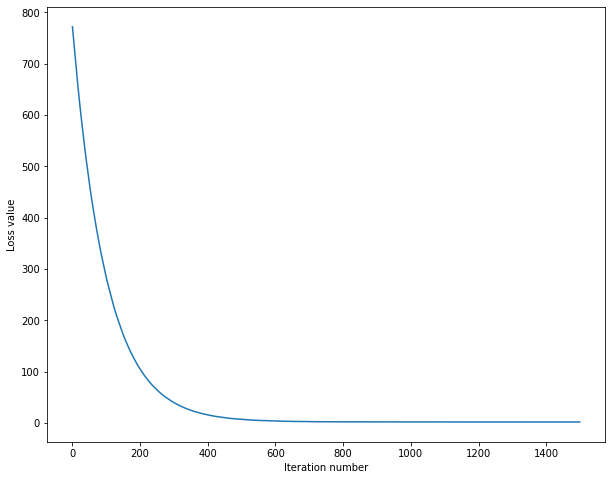

In [ ]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [6e-7, 9e-7, 1e-6, 3e-6]
regularization_strengths = [3e2, 6e2, 9e2, 1e3, 3e3, 6e3]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

num_iters = 1500

grid_search = [(lr_rate, reg) for lr_rate in learning_rates for reg in regularization_strengths]

for lr_rate, reg in grid_search:
  softmax = Softmax()
  loss_hist = softmax.train(X_train, y_train, learning_rate=lr_rate, reg=reg, \
                        num_iters=num_iters, verbose=False)
  
  y_train_pred = softmax.predict(X_train)
  train_accuracy = np.mean(y_train == y_train_pred)
  y_val_pred = softmax.predict(X_val)
  val_accuracy = np.mean(y_val == y_val_pred)
  
  results[(lr_rate, reg)] = (train_accuracy, val_accuracy)

  if val_accuracy > best_val:
    best_val = val_accuracy
    best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 6.000000e-07 reg 3.000000e+02 train accuracy: 0.357918 val accuracy: 0.337000
lr 6.000000e-07 reg 6.000000e+02 train accuracy: 0.383776 val accuracy: 0.389000
lr 6.000000e-07 reg 9.000000e+02 train accuracy: 0.393837 val accuracy: 0.395000
lr 6.000000e-07 reg 1.000000e+03 train accuracy: 0.388633 val accuracy: 0.394000
lr 6.000000e-07 reg 3.000000e+03 train accuracy: 0.386653 val accuracy: 0.389000
lr 6.000000e-07 reg 6.000000e+03 train accuracy: 0.360490 val accuracy: 0.368000
lr 9.000000e-07 reg 3.000000e+02 train accuracy: 0.386837 val accuracy: 0.370000
lr 9.000000e-07 reg 6.000000e+02 train accuracy: 0.397000 val accuracy: 0.387000
lr 9.000000e-07 reg 9.000000e+02 train accuracy: 0.401408 val accuracy: 0.405000
lr 9.000000e-07 reg 1.000000e+03 train accuracy: 0.399429 val accuracy: 0.400000
lr 9.000000e-07 reg 3.000000e+03 train accuracy: 0.380939 val accuracy: 0.384000
lr 9.000000e-07 reg 6.000000e+03 train accuracy: 0.364571 val accuracy: 0.375000
lr 1.000000e-06 reg 3.000000

In [ ]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy))

softmax on raw pixels final test set accuracy: 0.382000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ True


$\color{blue}{\textit Your Explanation:}$ SVM loss only cares that the score of the correct class are greater than a margin from the incorrect class scores. In such a case, the loss for that datapoint is zero. In contrast, the softmax classifier tries to put greater probability to the correct class. The loss in this case would be zero only when the correct class has a probability/confidence of 1.0. For this to happen, the classifier would need to return positive infinity for the correct class and negative infiinity for all other classes. Since this extreme output is not possible, a new data point would indeed add to the loss.



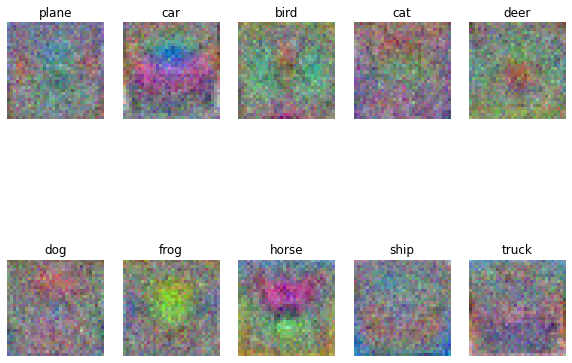

In [ ]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])